### IMPORTING LIBRARIES 

In [ ]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 5.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import efficientnet.keras as enet

### IMPORTING / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

Saving kaggle.json to kaggle.json
 97% 33.0M/34.1M [00:02<00:00, 20.1MB/s]
100% 34.1M/34.1M [00:02<00:00, 12.9MB/s]


In [ ]:
import zipfile
local_zip = '/content/alzheimers-dataset-4-class-of-images.zip'
data = zipfile.ZipFile(local_zip, 'r')
data.extractall('/content/Alzheimer_s Dataset')
data.close()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


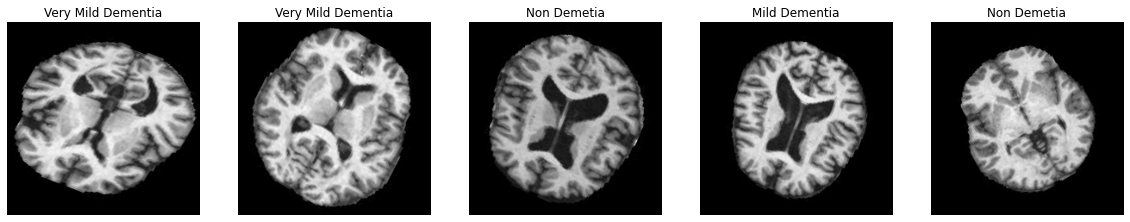

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [ ]:
base_model = enet.EfficientNetB3(input_shape=(224,224,3), 
                                 include_top=False,
                                 weights="imagenet")

44107200/44107200 [==============================] - 3s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 7, 7, 1536)       10783528  
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 1536)        0         
                                                                 
 flatten_1 (Flatten)         (None, 75264)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 75264)            301056    
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 2048)              154142720 
                                                                 
 batch_normalization_4 (Batc  (None, 2048)            

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# Model Compile 
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.AUC(name = 'auc'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Defining Callbacks

filepath = '/content/drive/MyDrive/ML_Course/best_weightsE.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.4373 - auc: 0.7563 - accuracy: 0.7443 - precision: 0.4869 - recall: 0.4273 - f1_score: 0.4404
Epoch 1: val_accuracy improved from -inf to 0.67424, saving model to /content/drive/MyDrive/ML_Course/best_weightsE.hdf5
33/33 [==============================] - 82s 2s/step - loss: 1.4373 - auc: 0.7563 - accuracy: 0.7443 - precision: 0.4869 - recall: 0.4273 - f1_score: 0.4404 - val_loss: 3.7421 - val_auc: 0.5924 - val_accuracy: 0.6742 - val_precision: 0.3447 - val_recall: 0.3363 - val_f1_score: 0.3404
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 1.2477 - auc: 0.7841 - accuracy: 0.7547 - precision: 0.5109 - recall: 0.4400 - f1_score: 0.4587
Epoch 2: val_accuracy improved from 0.67424 to 0.75464, saving model to /content/drive/MyDrive/ML_Course/best_weightsE.hdf5
33/33 [==============================] - 68s 2s/step - loss: 1.2477 - auc: 0.7841 - accuracy: 0.7547 - precision: 0.5109 - recall: 0.4400 - 

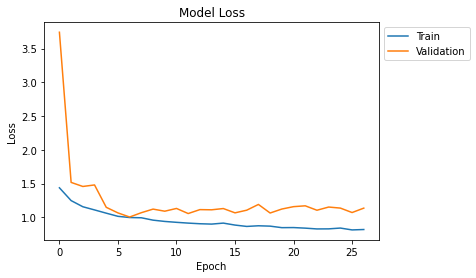

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

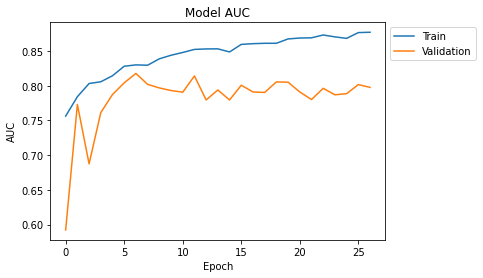

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

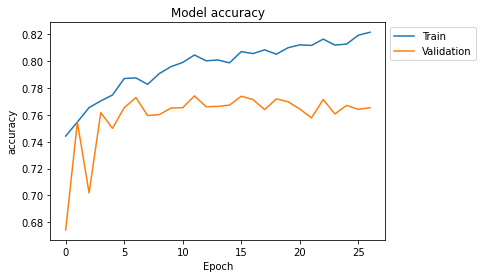

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical')

Found 1279 images belonging to 4 classes.


In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 4s 414ms/step - loss: 0.8822 - auc: 0.8635 - accuracy: 0.8061 - precision: 0.6306 - recall: 0.5418 - f1_score: 0.5823


[0.8821631073951721,
 0.8635181188583374,
 0.8060985207557678,
 0.6305732727050781,
 0.541829526424408,
 0.5822731256484985]

1/1 [==============================] - 0s 31ms/step
74.21 % chances are there that the image is class [2]


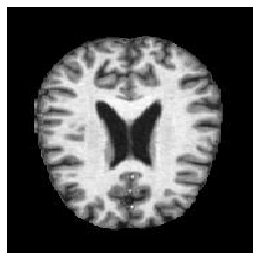

In [ ]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 27ms/step
71.31 % chances are there that the image is class [0]


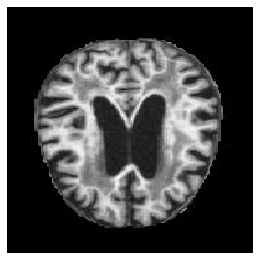

In [ ]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test/MildDemented/29 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 34ms/step
72.09 % chances are there that the image is class [1]


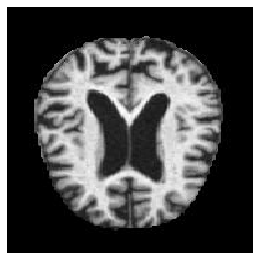

In [ ]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 32ms/step
58.66 % chances are there that the image is class [3]


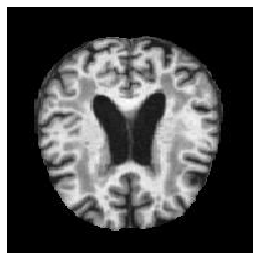

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

#Another Dataset

In [ ]:
model.load_weights('/content/drive/MyDrive/ML_Course/best_weightsE.hdf5')

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

Saving kaggle.json to kaggle.json
 93% 26.0M/28.0M [00:02<00:00, 16.0MB/s]
100% 28.0M/28.0M [00:02<00:00, 11.8MB/s]


In [ ]:
import zipfile
local_zip = '/content/alzheimer-mri-dataset.zip'
data = zipfile.ZipFile(local_zip, 'r')
data.extractall('/content/Alzheimer_s Dataset')
data.close()

In [ ]:
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Dataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 6400 images belonging to 4 classes.


In [ ]:
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.AUC(name = 'auc'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

50/50 [==============================] - 35s 425ms/step - loss: 0.9316 - auc: 0.8585 - accuracy: 0.8008 - precision: 0.6226 - recall: 0.5158 - f1_score: 0.5639


[0.9315997958183289,
 0.8585476279258728,
 0.80078125,
 0.6225952506065369,
 0.5157812237739563,
 0.5638667941093445]

1/1 [==============================] - 0s 28ms/step
64.8 % chances are there that the image is class [2]


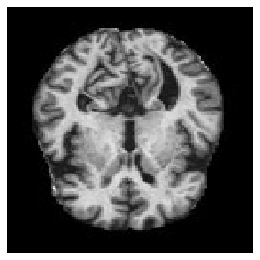

In [ ]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Dataset/Non_Demented/non_1013.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 46ms/step
59.39 % chances are there that the image is class [0]


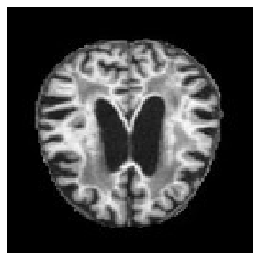

In [ ]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Dataset/Mild_Demented/mild_124.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 29ms/step
64.58 % chances are there that the image is class [1]


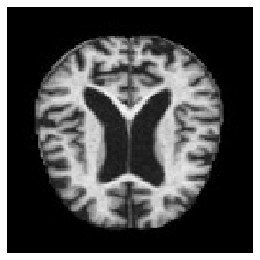

In [ ]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Dataset/Moderate_Demented/moderate_59.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 34ms/step
58.73 % chances are there that the image is class [3]


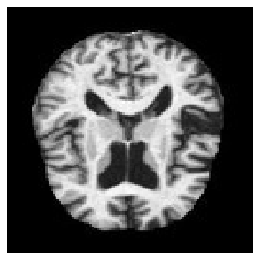

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Dataset/Very_Mild_Demented/verymild_1540.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)